#1. Install Dependencies

In [1]:
!pip install ultralytics roboflow torch torchvision timm matplotlib numpy opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 139.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


#2. Download Dataset From Roboflow

In [18]:
from roboflow import Roboflow
rf = Roboflow(api_key="JFzYPVMBJOOFASjuqO44")
project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Self-Driving-Car-3 in yolov8:: 100%|██████████| 59606/59606 [00:06<00:00, 9251.06it/s] 


#3. Exploratory Data Analysis (Class Counts, Example Image)

In [19]:
import json
import os
import matplotlib.pyplot as plt
from collections import Counter

label_path = "/content/Self-Driving-Car-3/export/labels"
labels = os.listdir(label_path)

class_counts = Counter()

for file in labels:
    with open(os.path.join(label_path, file), "r") as f:
        for line in f.readlines():
            cls = int(line.split()[0])
            class_counts[cls] += 1

print("Class Distribution:")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count}")


Class Distribution:
Class 1: 127873
Class 10: 7194
Class 2: 21491
Class 3: 5101
Class 4: 10838
Class 7: 3482
Class 6: 13673
Class 0: 3704
Class 8: 541
Class 5: 614
Class 9: 28


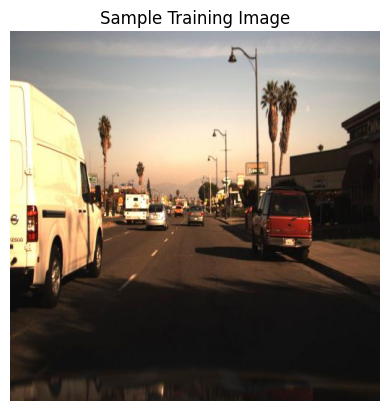

In [20]:
import cv2
import random

img_path = "/content/Self-Driving-Car-3/export/images"
sample_img = random.choice(os.listdir(img_path))

img = cv2.imread(os.path.join(img_path, sample_img))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Training Image")
plt.axis("off")
plt.show()


#4. Dataset Preparation: Train/Validation/Test Split Script

In [21]:
# 4. Dataset Preparation: Train/Validation/Test Split Script

import os
import shutil
import random

base_img = "/content/Self-Driving-Car-3/export/images"
base_lbl = "/content/Self-Driving-Car-3/export/labels"
dataset = "/content/Self-Driving-Car-3"

# Create YOLO folders
folders = [
    "train/images", "train/labels",
    "valid/images", "valid/labels",
    "test/images", "test/labels"
]

for f in folders:
    os.makedirs(f"{dataset}/{f}", exist_ok=True)

# Gather all images
images = [f for f in os.listdir(base_img) if f.endswith(".jpg")]
random.shuffle(images)

train_split = int(0.7 * len(images))
valid_split = int(0.9 * len(images))

train_imgs = images[:train_split]
valid_imgs = images[train_split:valid_split]
test_imgs  = images[valid_split:]


# Function to correctly distribute images + labels
def move_images(img_list, target):
    for img in img_list:
        img_src = os.path.join(base_img, img)
        img_dst = os.path.join(dataset, target, "images", img)
        shutil.copy(img_src, img_dst)

        label_name = img.replace(".jpg", ".txt")
        lbl_src = os.path.join(base_lbl, label_name)
        lbl_dst = os.path.join(dataset, target, "labels", label_name)

        if os.path.exists(lbl_src):
            shutil.copy(lbl_src, lbl_dst)
        else:
            print("Missing label for:", img)


move_images(train_imgs, "train")
move_images(valid_imgs, "valid")
move_images(test_imgs, "test")

print("\nDataset successfully split with REAL labels!")



Dataset successfully split with REAL labels!


In [22]:
import os

label_dir = "/content/Self-Driving-Car-3/train/labels"
sample = os.listdir(label_dir)[0]

with open(os.path.join(label_dir, sample)) as f:
    print(f"Sample label file:", sample)
    print(f.read())


Sample label file: 1478900862266557548_jpg.rf.68b3f97910f054e9c49c7904b1391ab1.txt
1 0.01171875 0.58203125 0.0224609375 0.125
1 0.1279296875 0.5546875 0.158203125 0.08984375
1 0.2392578125 0.5400390625 0.046875 0.0595703125
2 0.2646484375 0.55078125 0.05078125 0.158203125
1 0.3076171875 0.5361328125 0.060546875 0.0751953125
1 0.40234375 0.59765625 0.193359375 0.28125
1 0.5791015625 0.5537109375 0.1025390625 0.146484375
1 0.6162109375 0.5634765625 0.095703125 0.16015625
1 0.75390625 0.5703125 0.23828125 0.2568359375
1 0.8798828125 0.607421875 0.234375 0.3017578125


#5. Creating data.yaml

In [7]:
import yaml

data_yaml_content = {
    'names': [
        'biker',
        'car',
        'pedestrian',
        'trafficLight',
        'trafficLight-Green',
        'trafficLight-GreenLeft',
        'trafficLight-Red',
        'trafficLight-RedLeft',
        'trafficLight-Yellow',
        'trafficLight-YellowLeft',
        'truck'
    ],
    'nc': 11,
    'roboflow': {
        'license': 'MIT',
        'project': 'self-driving-car',
        'url': 'https://universe.roboflow.com/roboflow-gw7yv/self-driving-car/dataset/3',
        'version': 3,
        'workspace': 'roboflow-gw7yv'
    },
    'test': '/content/Self-Driving-Car-3/test/images',
    'train': '/content/Self-Driving-Car-3/train/images',
    'val': '/content/Self-Driving-Car-3/valid/images'
}

# Define the path where data.yaml should be created
data_yaml_path = '/content/Self-Driving-Car-3/data.yaml'

# Write the dictionary to the data.yaml file
with open(data_yaml_path, 'w') as file:
    yaml.dump(data_yaml_content, file, sort_keys=False)

print(f"'{data_yaml_path}' created successfully.")

'/content/Self-Driving-Car-3/data.yaml' created successfully.


#6. Train YOLOv8

In [8]:
from ultralytics import YOLO

# Use YOLO nano (fastest model)
model = YOLO("yolov8n.pt")

results = model.train(
    data="/content/Self-Driving-Car-3/data.yaml",
    epochs=5,
    imgsz=320,
    batch=4,
    workers=1,
    optimizer="SGD",
    conf=0.4,
    plots=False,
    verbose=False,
)

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=0.4, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Self-Driving-Car-3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=100, perspective=0.0, plots=False,

#7. YOLO Training Results

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "/content/runs/detect/train/results.csv"
df = pd.read_csv(csv_path)

df.head()


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,372.682,1.69434,1.61402,1.11904,0.29544,0.12048,0.20741,0.12119,1.54946,1.23001,1.01312,0.070006,0.003333,0.003333
1,2,732.067,1.65096,1.20919,1.09622,0.34954,0.12261,0.23188,0.13712,1.53215,1.15396,1.00160,0.038686,0.005346,0.005346
2,3,1088.320,1.64789,1.16425,1.09205,0.41923,0.11336,0.26177,0.14944,1.53473,1.09103,1.00627,0.006046,0.006040,0.006040
3,4,1442.900,1.60314,1.09633,1.07860,0.43596,0.17962,0.30344,0.17242,1.47988,1.02638,0.98298,0.004060,0.004060,0.004060
4,5,1796.990,1.52377,1.00282,1.04793,0.48868,0.18920,0.33729,0.19753,1.42622,0.97545,0.96507,0.002080,0.002080,0.002080


In [11]:
df.columns

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

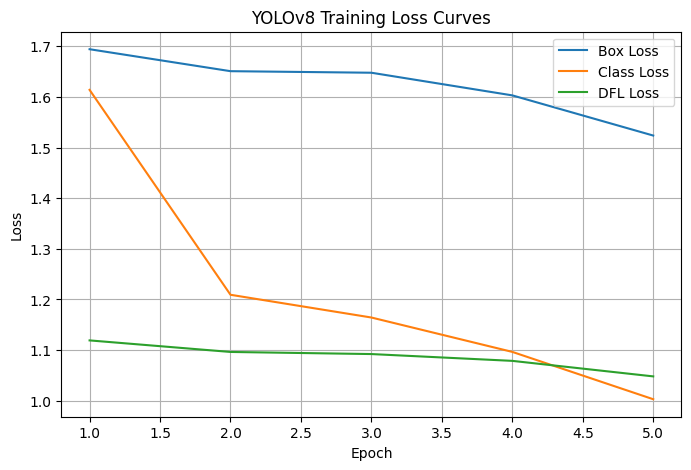

In [12]:
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss")
plt.plot(df["epoch"], df["train/dfl_loss"], label="DFL Loss")

plt.title("YOLOv8 Training Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


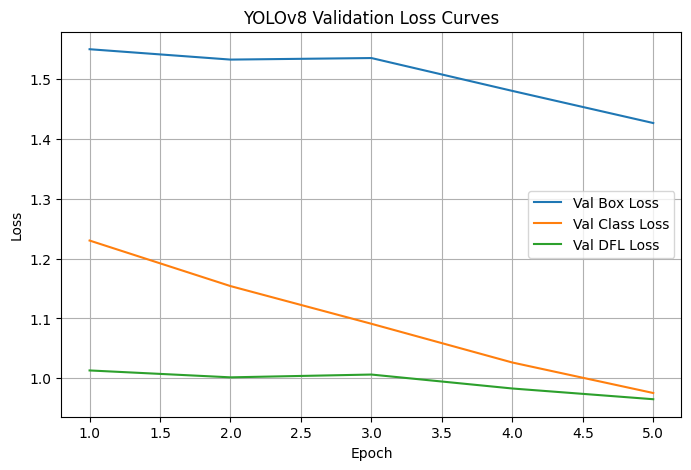

In [13]:
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss")
plt.plot(df["epoch"], df["val/dfl_loss"], label="Val DFL Loss")

plt.title("YOLOv8 Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


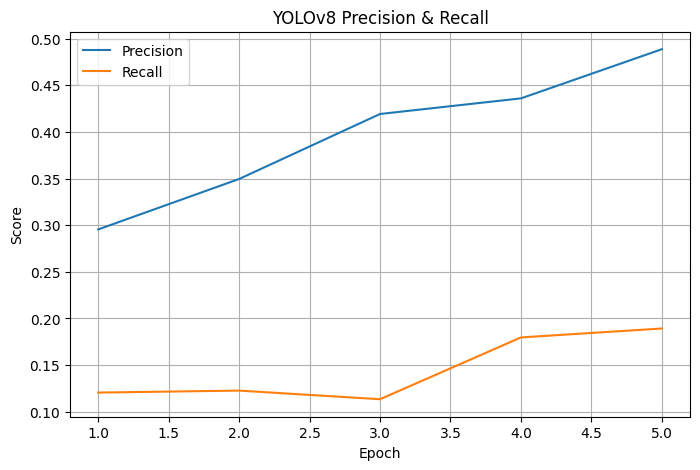

In [14]:
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")

plt.title("YOLOv8 Precision & Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


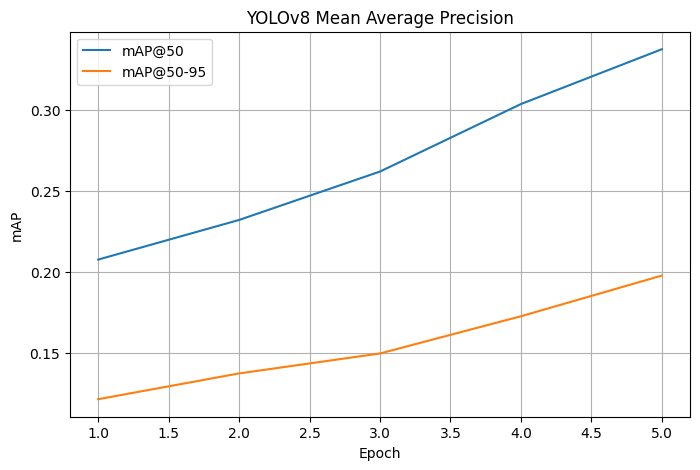

In [15]:
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@50-95")

plt.title("YOLOv8 Mean Average Precision")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.legend()
plt.grid(True)
plt.show()


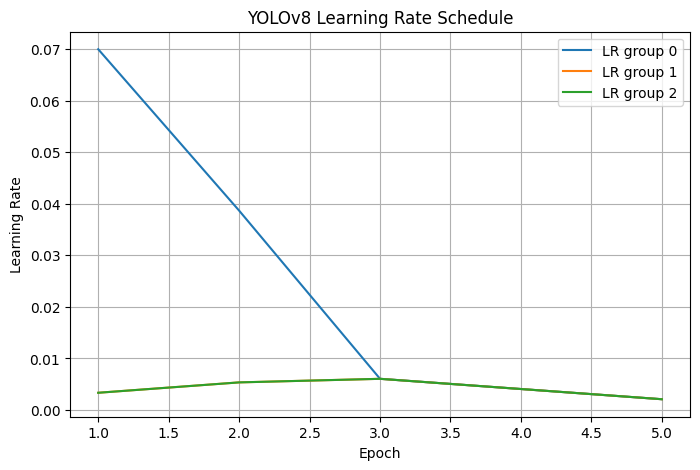

In [16]:
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["lr/pg0"], label="LR group 0")
plt.plot(df["epoch"], df["lr/pg1"], label="LR group 1")
plt.plot(df["epoch"], df["lr/pg2"], label="LR group 2")

plt.title("YOLOv8 Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.grid(True)
plt.show()


Saving 1478732160378046170_jpg.rf.qddYZAGxwVfRiJeMdZDn.jpg to 1478732160378046170_jpg.rf.qddYZAGxwVfRiJeMdZDn.jpg
Image uploaded: 1478732160378046170_jpg.rf.qddYZAGxwVfRiJeMdZDn.jpg

image 1/1 /content/1478732160378046170_jpg.rf.qddYZAGxwVfRiJeMdZDn.jpg: 640x640 4 cars, 2 trucks, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict
Annotated result saved at: /content/runs/detect/predict/1478732160378046170_jpg.rf.qddYZAGxwVfRiJeMdZDn.jpg


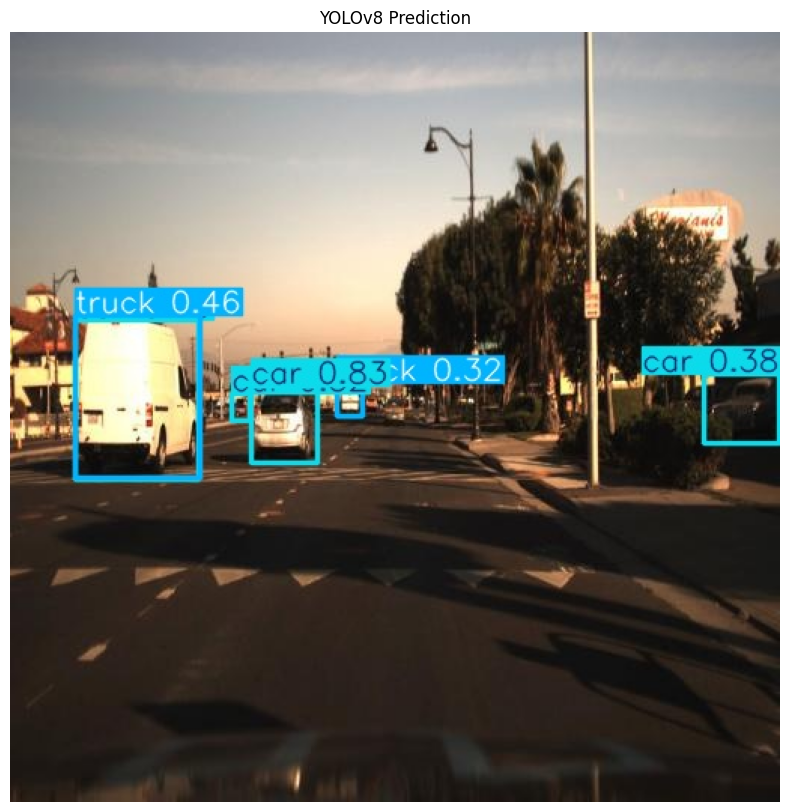

In [30]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from google.colab import files

# ------------------------------------------
# 1. Load your trained YOLO model
# ------------------------------------------
model = YOLO("/content/runs/detect/train/weights/best.pt")

# ------------------------------------------
# 2. Upload an image
# ------------------------------------------
uploaded = files.upload()  # user selects an image
image_path = list(uploaded.keys())[0]

print("Image uploaded:", image_path)

# ------------------------------------------
# 3. Run YOLO Detection
# ------------------------------------------
results = model.predict(
    source=image_path,
    save=True,              # saves annotated image
    conf=0.25,              # confidence threshold
    imgsz=640
)

# YOLO automatically saves predictions here:
output_path = results[0].save_dir + "/" + image_path

print("Annotated result saved at:", output_path)

# ------------------------------------------
# 4. Show annotated image
# ------------------------------------------
img = cv2.imread(output_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.title("YOLOv8 Prediction")
plt.show()


#Faster R-CNN

In [4]:
!pip install torch torchvision pycocotools matplotlib opencv-python


In [5]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.ops import box_iou
from torchvision.transforms import functional as F
import json
import cv2


In [6]:
class YOLODataset(Dataset):
    def __init__(self, img_dir, label_dir):
        self.img_dir = img_dir
        self.label_dir = label_dir

        all_images = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
        valid_images = []

        for img in all_images:
            label_path = os.path.join(label_dir, img.replace(".jpg", ".txt"))
            if not os.path.exists(label_path):
                continue
            if os.path.getsize(label_path) == 0:
                continue
            valid_images.append(img)

        self.images = valid_images
        print(f"Loaded {len(self.images)} valid images (skipped {len(all_images)-len(self.images)} empty)")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        lbl_path = os.path.join(self.label_dir, img_name.replace(".jpg", ".txt"))

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        boxes = []
        labels = []

        with open(lbl_path, "r") as f:
            for line in f:
                cls, cx, cy, bw, bh = map(float, line.split())

                x1 = (cx - bw/2) * w
                y1 = (cy - bh/2) * h
                x2 = (cx + bw/2) * w
                y2 = (cy + bh/2) * h

                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls))

        img = F.to_tensor(img)
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Faster R-CNN requires labels starting from 1
        labels += 1

        return img, {"boxes": boxes, "labels": labels}


In [7]:
train_dataset = YOLODataset(
    "/content/Self-Driving-Car-3/train/images",
    "/content/Self-Driving-Car-3/train/labels"
)

val_dataset = YOLODataset(
    "/content/Self-Driving-Car-3/valid/images",
    "/content/Self-Driving-Car-3/valid/labels"
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))




Loaded 18397 valid images (skipped 2463 empty)
Loaded 5241 valid images (skipped 719 empty)


In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,          # <— speeds up loading
    pin_memory=True,        # <— faster GPU transfer
    collate_fn=lambda x: tuple(zip(*x))
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=lambda x: tuple(zip(*x))
)


In [9]:
num_classes = 12  # 11 classes + background

model = fasterrcnn_resnet50_fpn(pretrained=True)
in_feat = model.roi_heads.box_predictor.cls_score.in_features

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_feat, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using: cuda


In [10]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

torch.amp.autocast("cuda")

In [16]:
from tqdm import tqdm

loss_history = []
val_loss_history = []
epochs = 5

scaler = torch.amp.GradScaler("cuda")  # NEW syntax

MAX_TRAIN_BATCHES = 500
MAX_VAL_BATCHES = 5

for epoch in range(epochs):

    print(f"\n Epoch {epoch+1}/{epochs}")

    # ==========================================
    # TRAINING
    # ==========================================
    model.train()
    total_loss = 0

    pbar = tqdm(train_loader, desc="Training", ncols=100)
    for batch_i, (imgs, targets) in enumerate(pbar):

        if batch_i >= MAX_TRAIN_BATCHES:
            break

        imgs = [i.to(device, non_blocking=True) for i in imgs]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            loss_dict = model(imgs, targets)
            loss = sum(loss_dict.values())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = total_loss / MAX_TRAIN_BATCHES
    loss_history.append(avg_train_loss)
    print(f" Train Loss: {avg_train_loss:.4f}")

    # ==========================================
    # VALIDATION
    # ==========================================
    val_total = 0

    # NOTE: Keep model in TRAIN mode, otherwise no loss is returned.
    model.train()

    pbar = tqdm(val_loader, desc="Validating", ncols=100)

    with torch.no_grad():
        for batch_i, (imgs, targets) in enumerate(pbar):

            if batch_i >= MAX_VAL_BATCHES:
                break

            imgs = [i.to(device, non_blocking=True) for i in imgs]
            targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

            with torch.amp.autocast("cuda"):
                loss_dict = model(imgs, targets)
                loss = sum(loss_dict.values())

            val_total += loss.item()
            pbar.set_postfix({"val_loss": f"{loss.item():.4f}"})

    avg_val_loss = val_total / MAX_VAL_BATCHES
    val_loss_history.append(avg_val_loss)
    print(f" Val Loss: {avg_val_loss:.4f}")



 Epoch 1/5


Training:  11%|████                                 | 500/4600 [02:16<18:38,  3.67it/s, loss=0.2602]


 Train Loss: 0.4747


Validating:   0%|▏                                | 5/1311 [00:00<04:15,  5.11it/s, val_loss=0.4546]


 Val Loss: 0.4386

 Epoch 2/5


Training:  11%|████                                 | 500/4600 [02:16<18:37,  3.67it/s, loss=0.4005]


 Train Loss: 0.4685


Validating:   0%|▏                                | 5/1311 [00:00<04:18,  5.05it/s, val_loss=0.4934]


 Val Loss: 0.4425

 Epoch 3/5


Training:  11%|████                                 | 500/4600 [02:16<18:38,  3.67it/s, loss=0.3250]


 Train Loss: 0.4593


Validating:   0%|▏                                | 5/1311 [00:01<04:26,  4.90it/s, val_loss=0.4955]


 Val Loss: 0.4484

 Epoch 4/5


Training:  11%|████                                 | 500/4600 [02:16<18:40,  3.66it/s, loss=0.4684]


 Train Loss: 0.4612


Validating:   0%|▏                                | 5/1311 [00:00<04:16,  5.09it/s, val_loss=0.4832]


 Val Loss: 0.4546

 Epoch 5/5


Training:  11%|████                                 | 500/4600 [02:16<18:35,  3.67it/s, loss=0.4604]


 Train Loss: 0.4518


Validating:   0%|▏                                | 5/1311 [00:00<04:13,  5.16it/s, val_loss=0.4889]

 Val Loss: 0.4340


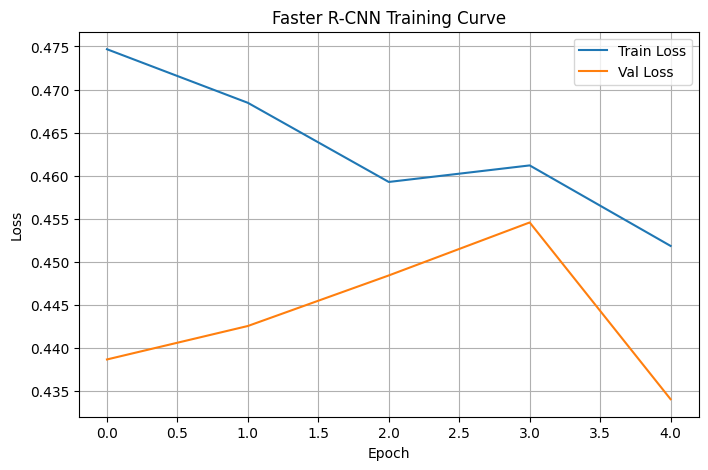

In [17]:
plt.figure(figsize=(8,5))
plt.plot(loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Faster R-CNN Training Curve")
plt.legend()
plt.grid()
plt.show()


Saving 1478732004963457051_jpg.rf.eaOhPku1yRLKOfbKs4eJ.jpg to 1478732004963457051_jpg.rf.eaOhPku1yRLKOfbKs4eJ.jpg


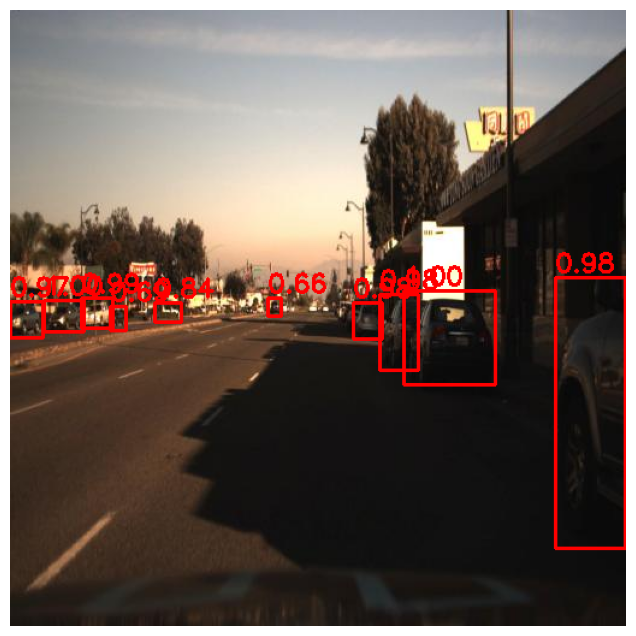

In [18]:
from google.colab import files
uploaded = files.upload()

img_path = list(uploaded.keys())[0]
img = Image.open(img_path).convert("RGB")
img_tensor = F.to_tensor(img).to(device)

model.eval()
with torch.no_grad():
    pred = model([img_tensor])[0]

boxes = pred["boxes"].cpu().numpy()
scores = pred["scores"].cpu().numpy()

img_np = np.array(img)

for box, score in zip(boxes, scores):
    if score > 0.5:
        x1,y1,x2,y2 = box.astype(int)
        cv2.rectangle(img_np,(x1,y1),(x2,y2),(255,0,0),2)
        cv2.putText(img_np, f"{score:.2f}", (x1,y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(255,0,0),2)

plt.figure(figsize=(10,8))
plt.imshow(img_np)
plt.axis("off")
plt.show()
